In [1]:
import gmplot
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from geopy.distance import vincenty
import pytz
from pytz import timezone
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN

import math
import time
import datetime
import os

# filedir = 'pathZ/C Brace/GPS Analysis'
filedir = '.'

In [2]:
!pwd

/Users/luca/Projects/Cbrace/DataAnalysis


In [3]:
pathZ = '/Volumes/RT&O'

## Wear Time w/ GPS Data

In [4]:
tz = timezone('US/Central')
def toUTC(d):
    return tz.normalize(tz.localize(d)).astimezone(pytz.utc)

In [5]:
def getDatetime(stringDTSeries):
    try:
        return [toUTC(datetime.datetime.strptime(DT,'%m/%d/%Y %I:%M %p')) for DT in stringDTSeries]
    except(ValueError):
        return [toUTC(datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M')) for DT in stringDTSeries]

In [6]:
#list all time zones
# for tz in pytz.all_timezones:
#     print(tz)
tz = timezone('US/Central')
date = datetime.datetime.now(tz=tz)
date.utcnow()

datetime.datetime(2017, 8, 14, 18, 23, 42, 894756)

In [7]:
#print( "Test: ", date, " = ", toUTC(date))

### Match wear time to GPS data

In [151]:
for device in ['CBrace', 'SCO', 'KAFO']:

    print(device)
    if device == 'KAFO':
        device2 = 'Baseline'
    else:
        device2 = device
    
    for i in range(8,32):

        if not(os.path.isfile(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device2 + '.csv')):

            try:
                try:
                    data = pd.read_csv(pathZ + '/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv(pathZ+'/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/Merged/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)
                except(OSError):
                    data = pd.read_csv(pathZ+'/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv')

                    try:
                        I = data.index
                        I = [i[0] for i in I]
                        
                    except(IndexError):
                        I = [i for i in data.iloc[:,0]]
                        I.pop(0)

                    data = pd.read_csv(pathZ+'/C Brace/Actigraph/Data/Home/CBR ' + str(i).zfill(2) + '/WearTime_' + device + '_Device.csv',
                                       skiprows=I.index('Date/Time Start')+2)

                DF=data[['Date/Time Start', 'Date/Time Stop']]

                WT_StartStop = DF.apply(getDatetime)
                WT_StartStop = pd.concat([WT_StartStop, data['Wear or Non-Wear']], axis=1)
                WT_StartStop = WT_StartStop[WT_StartStop['Wear or Non-Wear']=='Wear']

                GPSdata = pd.read_csv(filedir +  '/GPS Data/CBR' + str(i).zfill(2) + '_' + device2  + '.csv')
                
                GPS_TS = GPSdata['UTC DATE'] + ' ' + GPSdata['UTC TIME']

                try:
                    GPS_TS = [datetime.datetime.strptime(DT,'%m/%d/%Y %H:%M:%S') for DT in GPS_TS]
                except(ValueError):
                    GPS_TS = [datetime.datetime.strptime(DT,'%Y/%m/%d %H:%M:%S') for DT in GPS_TS]

                WT_StartStop.iloc[0,0]

                GPS_TS = pd.Series(GPS_TS)

                inds = (GPS_TS<WT_StartStop.iloc[0,1]) & (GPS_TS>WT_StartStop.iloc[0,0])

                GPS_WT = ['Non-Wear'] * len(inds)
                GPS_WT = pd.Series(GPS_WT)

                for Start, Stop in zip(WT_StartStop['Date/Time Start'], WT_StartStop['Date/Time Stop']):
                    inds = (GPS_TS<Stop) & (GPS_TS>Start)
                    GPS_WT[inds] = 'Wear'

                GPS = pd.concat([GPSdata, GPS_WT],axis=1).rename(index=int,columns={0:'Wear/Non-Wear'})

                GPS.to_csv(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device2 + '.csv')
            except(OSError):
                print('CBR' + str(i).zfill(2))                
                
                

CBrace
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR29
SCO
CBR09
CBR10
CBR12
CBR13
CBR14
CBR17
CBR18
CBR20
CBR23
CBR25
CBR29
KAFO
CBR08
CBR09
CBR10
CBR12
CBR13
CBR14
CBR16
CBR17
CBR18
CBR20
CBR23
CBR29


# Clustering and GMPlots

In [66]:
Data = pd.read_csv(pathZ + '/C Brace/GPS_data/CBR30_CBrace.csv',infer_datetime_format=True,parse_dates=[3,4,5,6])
Data.head()

,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z
0,1,1,FIXED,2017-01-13,2017-08-10 19:44:04,2017-01-13,2017-08-10 13:44:04,0,41.797036,N,88.201552,W,150.061157,0.371595,140.581840,0,0,0
1,2,1,FIXED,2017-01-13,2017-08-10 19:44:14,2017-01-13,2017-08-10 13:44:14,0,41.796991,N,88.201503,W,150.000107,0.347476,291.282261,0,0,0
2,3,1,FIXED,2017-01-13,2017-08-10 19:44:24,2017-01-13,2017-08-10 13:44:24,0,41.797028,N,88.201629,W,150.000504,0.168644,261.493957,0,0,0
3,4,1,FIXED,2017-01-13,2017-08-10 19:44:34,2017-01-13,2017-08-10 13:44:34,0,41.796972,N,88.202133,W,190.271286,0.034901,66.216543,0,0,0
4,5,1,FIXED,2017-01-13,2017-08-10 19:44:44,2017-01-13,2017-08-10 13:44:44,0,41.796976,N,88.202120,W,189.259796,0.082576,351.582684,0,0,0


In [56]:
Data = pd.read_csv(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device + '.csv')
Data.head()

,Unnamed: 0,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Wear/Non-Wear
0,0,1,1,FIXED,5/2/2017,21:08:22,5/2/2017,15:08:22,0,41.797107,N,88.202364,W,174.468796,0.993681,139.707157,0,0,0,Non-Wear
1,1,2,1,FIXED,5/2/2017,21:08:32,5/2/2017,15:08:32,0,41.797012,N,88.202256,W,166.793549,1.662868,12.820709,0,0,0,Non-Wear
2,2,3,1,FIXED,5/2/2017,21:08:42,5/2/2017,15:08:42,0,41.797092,N,88.202232,W,167.416092,14.338263,33.714078,0,0,0,Non-Wear
3,3,4,1,FIXED,5/2/2017,21:08:52,5/2/2017,15:08:52,0,41.797302,N,88.202044,W,169.546494,1.895775,168.816721,0,0,0,Non-Wear
4,4,5,1,FIXED,5/2/2017,21:09:02,5/2/2017,15:09:02,0,41.796949,N,88.201951,W,171.074081,33.230179,178.268735,0,0,0,Non-Wear


In [65]:
(Data['UTC TIME']-Data['LOCAL TIME']).unique()/1000000000/60/60

array([  6, -18], dtype='timedelta64[ns]')

In [8]:
D = {'CBrace':float('nan'), 'SCO':float('nan'), 'Baseline':float('nan')} #init empty dict with results

do_clustering = False # flag for performing clustering

for device in ['CBrace', 'SCO', 'Baseline']:

    gmap_large = gmplot.GoogleMapPlotter(41.787679, -88.135474,12) #home coordinates + initial zoom rendering
    gmap_small = gmplot.GoogleMapPlotter(41.787679, -88.135474,8)
    
    print(device)
    
    Time = [float('nan')] * 31; Freq = [float('nan')]*31; WTRatio = [float('nan')]*31; Dist = [float('nan')]*31;

    #loop over subj codes
    for i in range(8,32):

        print('CBR' + str(i).zfill(2))
        
        try:
            if do_clustering:
                Data = pd.read_csv(filedir + '/GPSWT/CBR' + str(i).zfill(2) + '_' + device + '.csv')

                Lat = Data.LATITUDE
                Lon = Data.LONGITUDE

                Data.loc[Data.iloc[:,12]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,12]=="W","LONGITUDE"]*-1
                dArray = Data[["LATITUDE","LONGITUDE"]].values
                
                dbscan = DBSCAN(metric='haversine', eps=50/6371000, min_samples=int(360*len(dArray)/200000), algorithm='ball_tree')
                t0 = time.clock()
                clusters = dbscan.fit(np.radians(dArray))
                t1 = time.clock()
                print(t1-t0)
                l=clusters.labels_ #label which cluster is each row (-1 = point not belonging to any cluster)
                print(len(np.unique(l)))
            
                Data['Cluster'] = pd.Series(l)
                Data.to_csv(filedir + '/GPSWT_wLabels/CBR' + str(i).zfill(2) + '_' + device + '.csv')
            else:
                Data = pd.read_csv(filedir + '/GPSWT_wLabels/CBR' + str(i).zfill(2) + '_' + device + '.csv')
                
                Lat = Data.LATITUDE
                Lon = Data.LONGITUDE

                dArray = Data[["LATITUDE","LONGITUDE"]].values
                
                l = np.asarray(Data['Cluster'])
            
            #METRICS
            f = sum(np.diff(l)!=0)/(len(l)-1)*6*60*24     #cluster switching freq
            t = [sum(l==c) for c in np.unique(l[l!=-1])]  #time spent in each cluster
            wt = [sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c) for c in np.unique(l[l!=-1])] #wear time ratio per cluster

            Freq[i-1] = f; Time[i-1] = t; WTRatio[i-1] = wt
            
            homeInd = np.argmax(t) #Home Cluster
            print(homeInd)
            offset = np.array([41.787679, -88.135474]) - np.array([np.mean(dArray[l==homeInd][:,0]), np.mean(dArray[l==homeInd][:,1])]) #anonymize home loc
            
#             homeSize = (np.max(dArray[l==homeInd][:,0])-np.min(dArray[l==homeInd][:,0]))*(np.max(dArray[l==homeInd][:,1])-np.min(dArray[l==homeInd][:,1]))
            homeSize = sum(l==homeInd)
    
            #home cluster center and geodesic distance of each cluster from home
            home_lat = ( np.max(dArray[l==homeInd][:,0]) + np.min(dArray[l==homeInd][:,0]) )/2
            home_long = ( np.max(dArray[l==homeInd][:,1]) + np.min(dArray[l==homeInd][:,1]) )/2
            home = np.array([[home_lat, home_long]])
            d = [] #distance of each point from home cluster
            for k in np.arange(len(dArray)):
                d.append((vincenty((home), (dArray[k,:])).meters/1000))
            d = np.asarray(d)
            meandist = [np.mean(d[l==c]) for c in np.unique(l[~((l==-1) | (l==homeInd))])] 
            
            Dist[i-1] = meandist #mean dist of each cluster point from home
            
    
            # array for lats and longs
            m1_all = []
            m2_all = []
            # array for colors
            col_all = []
            
            
            #Loop over clusters and Add to GMAP Plot
            for c in np.unique(l[l!=-1]):
                m = np.array([np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]) + offset
                # Size based on physical space covered by cluster
#                 s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))
#                 s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))
#                 print(s1*s2)

                # Size based on time spent in cluster
                s1 = sum(l==c)
                s2 = 1
#                 print(math.sqrt(s1*s2))

                # colorscale based on weartime fraction
                col = sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c)
                
                m1_all.append(m[0])
                m2_all.append(m[1])
                col_all.append(col)
                
                gmap_large.scatter([m[0], m[0]],[m[1], m[1]],
                                   color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*500, marker=False)
            
                gmap_small.scatter([m[0], m[0]],[m[1], m[1]],
                                   color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*80, marker=False)
            
        except(OSError):
            print('No File')
            
    DF = pd.DataFrame({'Time':Time, 'WTRatio':WTRatio, 'Freq':Freq, 'Dist':Dist})
    D[device] = DF
    
    
    gmap_large.draw(device + "_large.html")
    gmap_small.draw(device + "_small.html")
    
Results = pd.Panel(D)

CBrace
CBR08
0
CBR09
No File
CBR10
No File
CBR11
0
CBR12
No File
CBR13
No File
CBR14
No File
CBR15
1
CBR16
0
CBR17
No File
CBR18
No File
CBR19
0
CBR20
No File
CBR21
1
CBR22
2
CBR23
No File
CBR24
0
CBR25
0
CBR26
0
CBR27
0
CBR28
0
CBR29
No File
CBR30
0
CBR31
0
SCO
CBR08
1
CBR09
No File
CBR10
No File
CBR11
0
CBR12
No File
CBR13
No File
CBR14
No File
CBR15
0
CBR16
0
CBR17
No File
CBR18
No File
CBR19
0
CBR20
No File
CBR21
1
CBR22
0
CBR23
No File
CBR24
0
CBR25
No File
CBR26
0
CBR27
0
CBR28
0
CBR29
No File
CBR30
1
CBR31
0
Baseline
CBR08
No File
CBR09
No File
CBR10
No File
CBR11
0
CBR12
No File
CBR13
No File
CBR14
No File
CBR15
0
CBR16
0
CBR17
No File
CBR18
No File
CBR19
0
CBR20
No File
CBR21
0
CBR22
1
CBR23
No File
CBR24
1
CBR25
0
CBR26
1
CBR27
0
CBR28
0
CBR29
No File
CBR30
0
CBR31
0


In [9]:
Results

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 31 (major_axis) x 4 (minor_axis)
Items axis: Baseline to SCO
Major_axis axis: 0 to 30
Minor_axis axis: Dist to WTRatio

In [10]:
Results.to_hdf('./Results_panel.h5','key')

/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['Baseline', 'CBrace', 'SCO']]

  warnings.warn(ws, PerformanceWarning)


In [10]:
Results = pd.read_hdf('./Results_panel.h5','key')

In [ ]:
Resultsdf = Results.to_frame(filter_observations=False)
Resultsdf = Resultsdf.dropna(how='all')

In [12]:
Results

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 31 (major_axis) x 4 (minor_axis)
Items axis: Baseline to SCO
Major_axis axis: 0 to 30
Minor_axis axis: Dist to WTRatio

In [267]:
Resultsdf = Results.to_frame(filter_observations=False)

In [436]:
Resultsdf = Resultsdf.dropna(how='all')

In [13]:
Resultsdf.head()

Baseline  \
major minor                                                        
7     Dist                                                   NaN   
      Freq                                                   NaN   
      Time                                                   NaN   
      WTRatio                                                NaN   
10    Dist     [4.24642121996, 8.79473462239, 1.36003494179, ...   

                                                          CBrace  \
major minor                                                        
7     Dist     [0.894711133359, 0.568997266535, 16.0446224275...   
      Freq                                              30.94359   
      Time     [89620, 379, 379, 426, 317, 282, 255, 221, 357...   
      WTRatio  [0.143740236554, 0.976253298153, 0.98416886543...   
10    Dist     [4.24165669476, 3.59365734916, 3.01367116116, ...   

                                                             SCO  
major minor                                                       
7     Dist     [0.863949908873, 8.45253926685, 8.78996936089,...  
      Freq                                              52.46645  
      Time     [1333, 74413, 804, 678, 686, 495, 702, 559, 51...  
      WTRatio  [0.319579894974, 0.137744748901, 0.0, 1.0, 0.0...  
10    Dist     [4.27138341236, 0.7472206043, 1.34239405481, 6...

In [100]:
Resultsdf.to_csv('Resultsdf.csv')

In [25]:
def getNClusters(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(len(e))
    
    return X

In [30]:
N_Clusters = Results.minor_xs('Time').apply(getNClusters) # number of clusters for each subject/brace
N_Clusters = N_Clusters.dropna(axis=0,how='all')
newidx = np.array(N_Clusters.index)
newidx +=1
print(newidx)
N_Clusters.index = newidx
# N_Clusters = N_Clusters.drop(N_Clusters.index[2]) #drop subj 13
N_Clusters

[ 8 11 15 16 19 21 22 24 25 26 27 28 30 31]


,Baseline,CBrace,SCO
8,NaN,10,27
11,13,11,11
15,18,30,7
16,15,11,12
19,2,3,1
21,10,13,9
22,17,31,38
24,8,6,3
25,6,4,NaN
26,21,7,10


/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


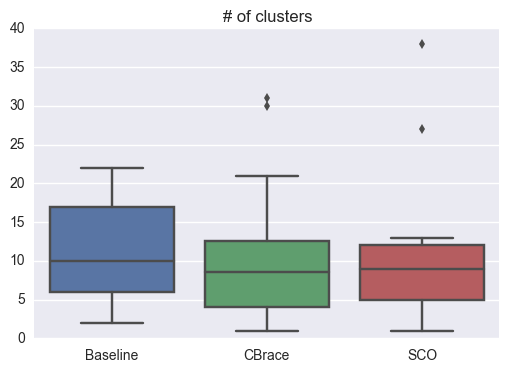

In [31]:
ax=sns.boxplot(N_Clusters)
plt.title('# of clusters')
plt.savefig('./Figs/NClusters.jpg')

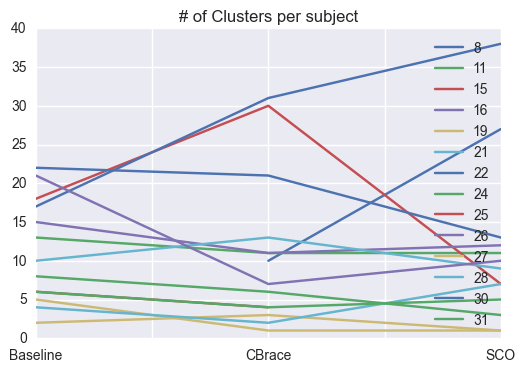

In [32]:
ax = N_Clusters.T.plot()
plt.title('# of Clusters per subject')
plt.savefig('./Figs/NClustersInd.jpg')

Only 2 individuals seem to have an increasing number of clusters with the Cbrace. The number of clusters stays pretty much constant for all other subjects 

In [33]:
def getTimeAverage(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.mean(np.sort(e)[0:len(e)-1])/np.max(e)) # Average time spent in other clusters relative to Home

    return X

def getTimeRatio(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.sum(np.sort(e)[0:len(e)-1])/np.max(e)) # Total time spent in other clusters relative to Home

    return X

def getMedianDist(S):
    X = []
    for e in S:
        try:
            check = any(np.isnan(e))
        except(TypeError):
            check = np.isnan(e)
            
        if check:
            X.append(e)
        else:
            X.append(np.median(e))
    
    return X

In [98]:
np.median(np.array([]))

/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


nan

In [36]:
#Median Distance of clusters from home cluster in km
MedianDist = Results.minor_xs('Dist').apply(getMedianDist) #Median distance of clusters from home
MedianDist = MedianDist.dropna(axis=0,how='all')
newidx = np.array(MedianDist.index)
newidx +=1
print(newidx)
MedianDist.index = newidx
MedianDist
#2 persons traveled outside of the US

[ 8 11 15 16 19 21 22 24 25 26 27 28 30 31]


/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,Baseline,CBrace,SCO
8,NaN,9.154233,3.855096
11,5.378452,3.303664,2.962211
15,35.971704,7147.576702,30.342052
16,10.919671,38.605277,42.215672
19,36.333891,29.728751,NaN
21,6.307820,10.900297,5.339401
22,458.956047,21.147507,12.738641
24,3.038788,6.709191,2.872137
25,2.355511,13.479740,NaN
26,5.205795,5.290579,5.182542


/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


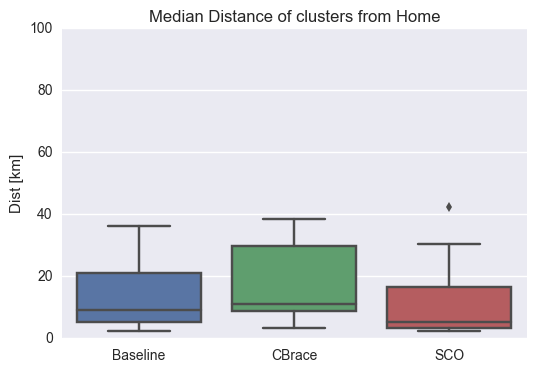

In [153]:
# g = sns.boxplot(MedianDist.iloc[~((MedianDist.index==31)|(MedianDist.index==15)),:])
g = sns.boxplot(MedianDist)
yl = g.set_ylim(0,100)
plt.title('Median Distance of clusters from Home')
g.set_ylabel('Dist [km]')
plt.savefig('./Figs/Distance.jpg')

In [41]:
MeanTime = Results.minor_xs('Time').apply(getTimeAverage) # Average time spent in other clusters relative to Home
MeanTime = MeanTime.dropna(how='all')
newidx = np.array(MeanTime.index)
newidx +=1
MeanTime.index = newidx
MeanTime

/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,Baseline,CBrace,SCO
8,NaN,0.003460,0.006708
11,0.045043,0.034998,0.025342
15,0.010160,0.072995,0.012993
16,0.009257,0.009464,0.007977
19,0.340683,0.023807,NaN
21,0.006021,0.020076,0.027329
22,0.047953,0.097836,0.071572
24,0.007640,0.003144,0.003438
25,0.003227,0.020490,NaN
26,0.014608,0.007331,0.010270


In [42]:
RatioTime = Results.minor_xs('Time').apply(getTimeRatio) # Total time spent in other clusters relative to Home
RatioTime = RatioTime.dropna(how='all')
newidx = np.array(RatioTime.index)
newidx +=1
RatioTime.index = newidx
RatioTime

,Baseline,CBrace,SCO
8,NaN,0.031143,0.174405
11,0.540516,0.349977,0.253422
15,0.172723,2.116844,0.077958
16,0.129605,0.094640,0.087749
19,0.340683,0.047614,0.000000
21,0.054185,0.240909,0.218635
22,0.767242,2.935082,2.648148
24,0.053479,0.015719,0.006876
25,0.016134,0.061469,NaN
26,0.292166,0.043987,0.092428


/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


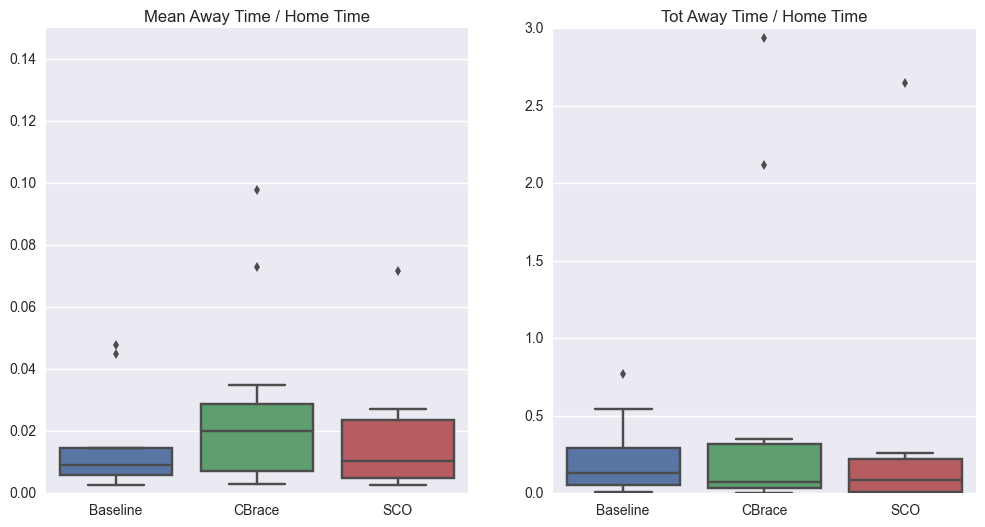

In [44]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
sns.boxplot(MeanTime,ax=ax)
ax.set_title('Mean Away Time / Home Time')
ax.set_ylim(0.0,0.15)
ax2 = fig.add_subplot(1,2,2)
sns.boxplot(RatioTime,ax=ax2)
ax2.set_title('Tot Away Time / Home Time')
plt.savefig('./Figs/Mean_Tot_Time.jpg')


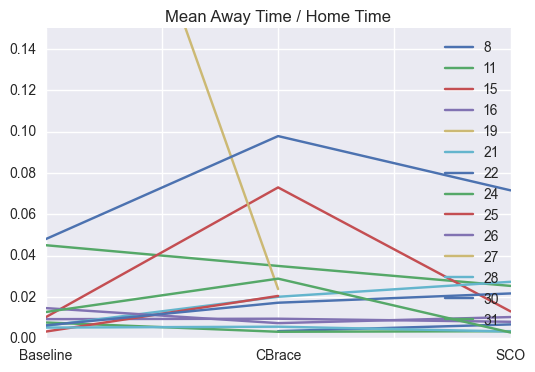

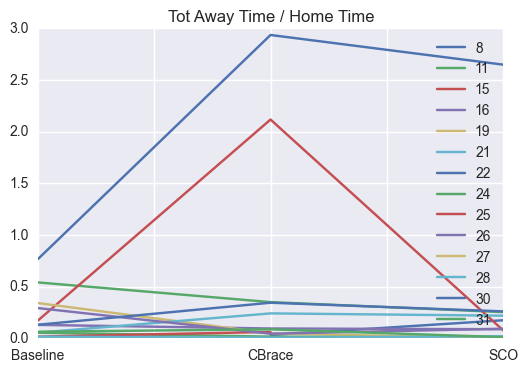

In [46]:
ax = fig.add_subplot(121)
ax = MeanTime.T.plot()
ax.set_title('Mean Away Time / Home Time')
ax.set_ylim(0.0,0.15)
plt.savefig('./Figs/Mean_Time_ind.jpg')
ax2 = fig.add_subplot(122)
ax2 = RatioTime.T.plot()
ax2.set_title('Tot Away Time / Home Time')
# ax2.set_ylim(0.0,1.0)
plt.savefig('./Figs/Tot_Time_ind2.jpg')

In [47]:
def getWTimeAverage(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        ind = np.argmax(S['Time'])
        d = pd.Series(S['WTRatio'])
        
        return d

def getWTimeHome(S):
    
    try:
        check = any(np.isnan(S['Time']))
    except(TypeError):
        check = np.isnan(S['Time'])
    
    if check:
        return float('nan')
    else:
        return S['WTRatio'][np.argmax(S['Time'])]


In [48]:
DHome = {};
DMean = {};

for C in Results.items:

    DHome[C] = Results[C].apply(getWTimeHome,axis=1)
    DMean[C] = Results[C].apply(getWTimeAverage,axis=1).apply(np.mean)
    
WTHome = pd.DataFrame(DHome) # WT ratio in Home cluster
WTMean = pd.DataFrame(DMean) # Average WT ratio in away clusters

In [49]:
WTHome = WTHome.dropna(how='all')
newidx = np.array(WTHome.index)
newidx +=1
WTHome.index = newidx
WTHome

,Baseline,CBrace,SCO
8,NaN,0.143740,0.137745
11,0.008327,0.148151,0.109427
15,0.389384,0.000000,0.406120
16,0.255613,0.268135,0.288073
19,0.006130,0.005987,0.032585
21,0.290227,0.016714,0.036156
22,0.042928,0.073517,0.404139
24,0.395885,0.133582,0.057020
25,0.499585,0.224842,NaN
26,0.445967,0.044487,0.222909


In [50]:
WTMean = WTMean.dropna(how='all')
newidx = np.array(WTMean.index)
newidx +=1
WTMean.index = newidx
WTMean

,Baseline,CBrace,SCO
8,NaN,0.804085,0.413161
11,0.005483,0.521121,0.500205
15,0.818301,0.000000,0.846780
16,0.782224,0.932571,0.940673
19,0.014621,0.040235,0.032585
21,0.555857,0.010631,0.016208
22,0.659244,0.860252,0.835427
24,0.876679,0.513440,0.685673
25,0.916597,0.306210,NaN
26,0.952073,0.834085,0.922291


In [126]:
N_Clusters

,Baseline,CBrace,SCO
8,NaN,10,27
11,13,11,11
15,18,30,7
16,15,11,12
19,2,3,1
21,10,13,9
22,17,31,38
24,8,6,3
25,6,4,NaN
26,21,7,10


/Users/luca/anaconda/envs/sklearn015/lib/python3.4/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


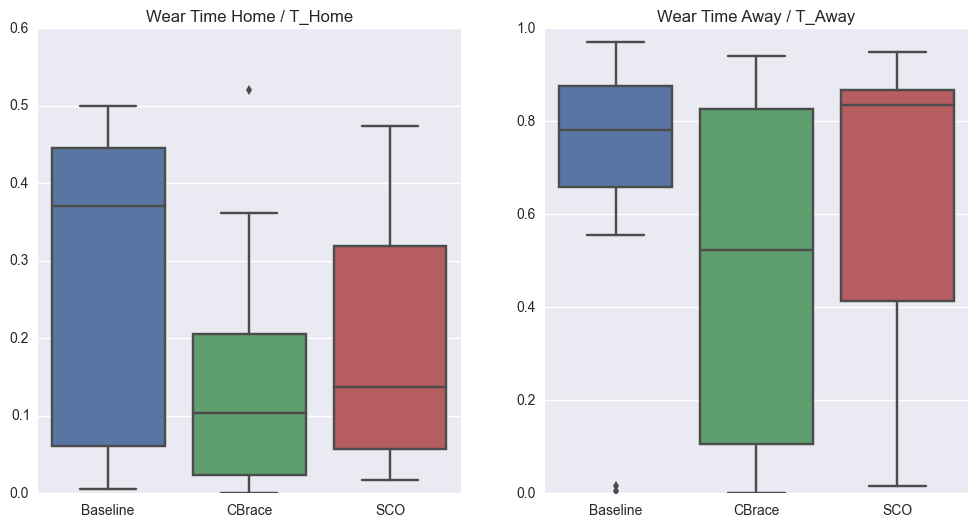

In [51]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
sns.boxplot(WTHome,ax=ax)
ax.set_title('Wear Time Home / T_Home')
ax2 = fig.add_subplot(122)
sns.boxplot(WTMean,ax=ax2)
ax2.set_title('Wear Time Away / T_Away')
plt.savefig('./Figs/WearTimeRatio.jpg')

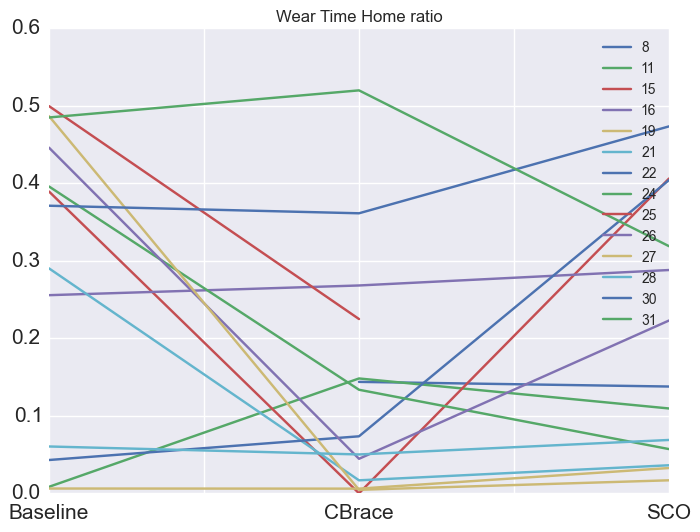

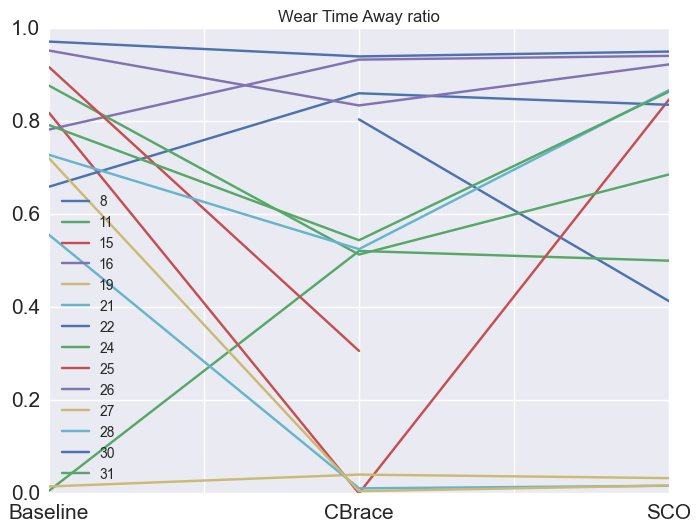

In [127]:
ax = fig.add_subplot(211)
ax = WTHome.T.plot(figsize=(8,6),fontsize=15)
ax.set_title('Wear Time Home ratio')

plt.savefig('./Figs/WearTimeHome_ind.jpg')
ax2 = fig.add_subplot(212)
ax2 = WTMean.T.plot(figsize=(8,6),fontsize=15)
ax2.set_title('Wear Time Away ratio')
plt.savefig('./Figs/WearTimeAway_ind.jpg')

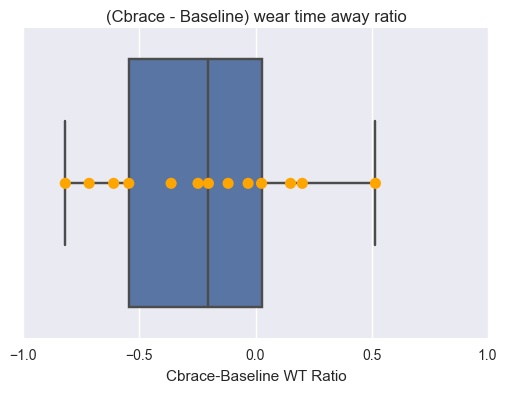

In [134]:
sns.boxplot(WTMean['CBrace']-WTMean['Baseline'])
sns.swarmplot(WTMean['CBrace']-WTMean['Baseline'],size=8,color='orange')
plt.title('(Cbrace - Baseline) wear time away ratio ')
plt.xlabel('Cbrace-Baseline WT Ratio')
plt.xlim(-1,1)
plt.savefig('./Figs/WearTimeAway_ind2.jpg')

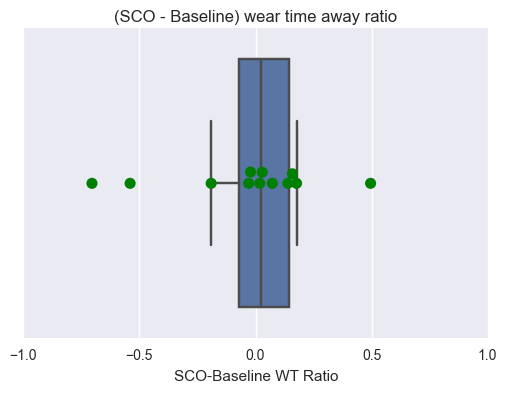

In [135]:
sns.boxplot(WTMean['SCO']-WTMean['Baseline'])
sns.swarmplot(WTMean['SCO']-WTMean['Baseline'],size=8,color='green')
plt.title('(SCO - Baseline) wear time away ratio ')
plt.xlabel('SCO-Baseline WT Ratio'); plt.xlim(-1,1)
plt.savefig('./Figs/WearTimeAway_ind2.jpg')

## Correlation between Wear Time Ratio at Home and Wear Time away

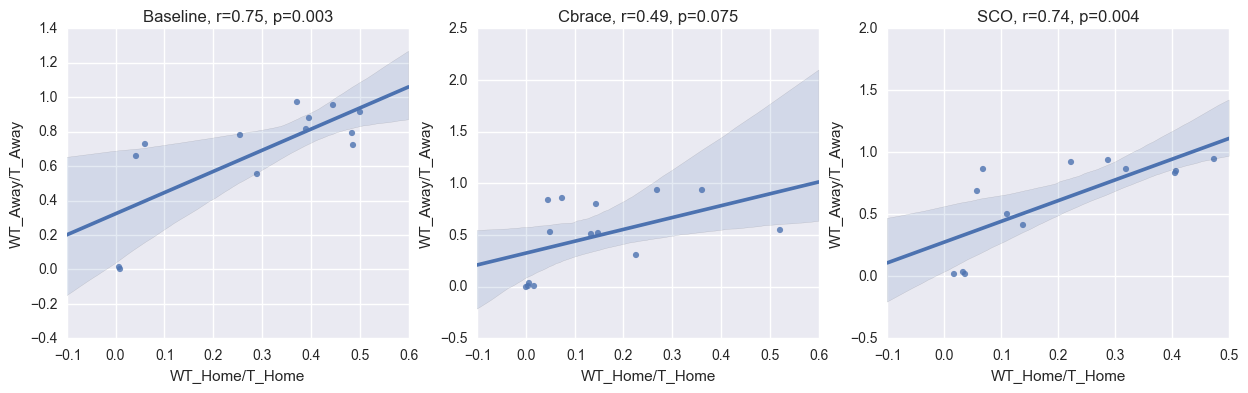

In [137]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(131)
ax1 = sns.regplot(x=WTHome.Baseline,y=WTMean.Baseline)
r,p=pearsonr(WTHome.Baseline[~np.isnan(WTMean.Baseline)],WTMean.Baseline[~np.isnan(WTMean.Baseline)])
ax1.set_title('Baseline, r=%.2f, p=%.3f'%(r,p))
ax1.set_xlabel('WT_Home/T_Home')
ax1.set_ylabel('WT_Away/T_Away')

fig.add_subplot(132)
ax1 = sns.regplot(x=WTHome.CBrace,y=WTMean.CBrace)
r,p=pearsonr(WTHome.CBrace,WTMean.CBrace)
ax1.set_title('Cbrace, r=%.2f, p=%.3f'%(r,p))
ax1.set_xlabel('WT_Home/T_Home')
ax1.set_ylabel('WT_Away/T_Away')


fig.add_subplot(133)
ax1 = sns.regplot(x=WTHome.SCO,y=WTMean.SCO)
r,p=pearsonr(WTHome.SCO[~np.isnan(WTMean.SCO)],WTMean.SCO[~np.isnan(WTMean.SCO)])
ax1.set_title('SCO, r=%.2f, p=%.3f'%(r,p))
ax1.set_xlabel('WT_Home/T_Home')
ax1.set_ylabel('WT_Away/T_Away')

plt.savefig('./Figs/CorrWearTime.jpg')

In [124]:
N_Clusters

,Baseline,CBrace,SCO
8,NaN,10,27
11,13,11,11
15,18,30,7
16,15,11,12
19,2,3,1
21,10,13,9
22,17,31,38
24,8,6,3
25,6,4,NaN
26,21,7,10


In [95]:
MedianDist

,Baseline,CBrace,SCO
8,NaN,9.154233,3.855096
11,5.378452,3.303664,2.962211
15,35.971704,7147.576702,30.342052
16,10.919671,38.605277,42.215672
19,36.333891,29.728751,NaN
21,6.307820,10.900297,5.339401
22,458.956047,21.147507,12.738641
24,3.038788,6.709191,2.872137
25,2.355511,13.479740,NaN
26,5.205795,5.290579,5.182542


In [102]:
WTMean

,Baseline,CBrace,SCO
8,NaN,0.804085,0.413161
11,0.005483,0.521121,0.500205
15,0.818301,0.000000,0.846780
16,0.782224,0.932571,0.940673
19,0.014621,0.040235,0.032585
21,0.555857,0.010631,0.016208
22,0.659244,0.860252,0.835427
24,0.876679,0.513440,0.685673
25,0.916597,0.306210,NaN
26,0.952073,0.834085,0.922291


# CHECK w NICK: How can you have time away in people with only 1 cluster (only home)?

## Correlation between wear time away and median distance traveled

In [112]:
WTMean.CBrace[~np.isnan(MedianDist.CBrace)]

8     0.804085
11    0.521121
15    0.000000
16    0.932571
19    0.040235
21    0.010631
22    0.860252
24    0.513440
25    0.306210
26    0.834085
28    0.525049
30    0.939483
31    0.544247
Name: CBrace, dtype: float64

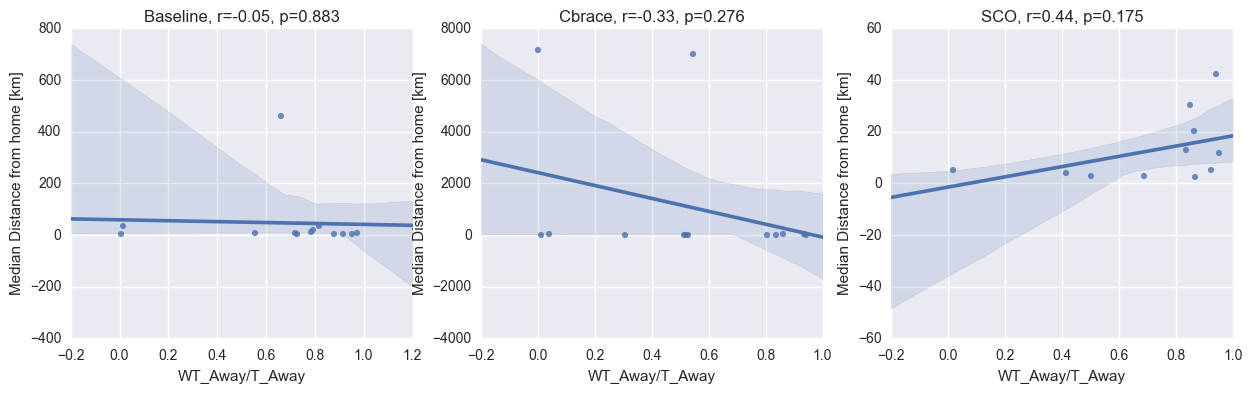

In [154]:
fig = plt.figure(figsize=(15,4))
fig.add_subplot(131)
ax1 = sns.regplot(x=WTMean.Baseline,y=MedianDist.Baseline)
r,p=pearsonr(WTMean.Baseline[~np.isnan(MedianDist.Baseline)],MedianDist.Baseline[~np.isnan(MedianDist.Baseline)])
ax1.set_title('Baseline, r=%.2f, p=%.3f'%(r,p))
ax1.set_xlabel('WT_Away/T_Away')
ax1.set_ylabel('Median Distance from home [km]')

fig.add_subplot(132)
ax2 = sns.regplot(x=WTMean.CBrace,y=MedianDist.CBrace)
r,p=pearsonr(WTMean.CBrace[~np.isnan(MedianDist.CBrace)],MedianDist.CBrace[~np.isnan(MedianDist.CBrace)])
ax2.set_title('Cbrace, r=%.2f, p=%.3f'%(r,p))
ax2.set_xlabel('WT_Away/T_Away')
ax2.set_ylabel('Median Distance from home [km]')


fig.add_subplot(133)
ax3 = sns.regplot(x=WTMean.SCO,y=MedianDist.SCO)
r,p=pearsonr(WTMean.SCO[~np.isnan(MedianDist.SCO)],MedianDist.SCO[~np.isnan(MedianDist.SCO)])
ax3.set_title('SCO, r=%.2f, p=%.3f'%(r,p))
ax3.set_xlabel('WT_Away/T_Away')
ax3.set_ylabel('Median Distance from home [km]')

plt.savefig('CorrDistWearTime.jpg')

In [26]:
WTHome['SCO']-WTHome['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    0.126240
11         NaN
12         NaN
13         NaN
14    0.011020
15    0.044359
16         NaN
17         NaN
18    0.026099
19         NaN
20   -0.255020
21    0.717707
22         NaN
23   -0.335233
24         NaN
25   -0.219963
26   -0.469787
27    0.007255
28         NaN
29    0.105970
30   -0.161179
dtype: float64

In [27]:
RatioTime['SCO']-RatioTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.391693
11         NaN
12         NaN
13         NaN
14   -0.118413
15   -0.057328
16         NaN
17         NaN
18   -0.340794
19         NaN
20    0.170600
21    0.763669
22         NaN
23   -0.086400
24         NaN
25   -0.275909
26   -0.068170
27   -0.000190
28         NaN
29    0.066273
30   -0.073237
dtype: float64

In [28]:
MeanTime['SCO']-MeanTime['Baseline']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10   -0.025672
11         NaN
12         NaN
13         NaN
14    0.006098
15   -0.000130
16         NaN
17         NaN
18   -0.166028
19         NaN
20    0.020185
21   -0.024201
22         NaN
23   -0.004423
24         NaN
25   -0.003413
26   -0.011552
27   -0.004198
28         NaN
29    0.014587
30   -0.009623
dtype: float64

In [31]:
np.mean(N_Clusters['CBrace']-N_Clusters['Baseline'])

0.15384615384615385

In [32]:
np.mean(N_Clusters['SCO']-N_Clusters['Baseline'])

-2.0

In [33]:
np.mean(N_Clusters['CBrace']-N_Clusters['SCO'])

0.84615384615384615

In [34]:
np.mean(MeanTime['CBrace']-MeanTime['SCO'])

0.011510129269334406

In [35]:
np.mean(RatioTime['CBrace']-RatioTime['SCO'])

0.35101858093408639

## Testing Code

In [11]:
Data = pd.read_csv(filedir + '/GPSWT/CBR31_CBrace.csv')

In [12]:
Data

,Unnamed: 0,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,N/S,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Wear/Non-Wear
0,0,1,1,FIXED,2016/11/21,21:3:22,2016/11/21,15:3:22,0,41.797054,N,88.201714,W,205.244080,0.458775,251.505436,0,0,0,Wear
1,1,2,1,FIXED,2016/11/21,21:3:32,2016/11/21,15:3:32,0,41.796997,N,88.201946,W,196.010895,0.188341,271.555677,0,0,0,Wear
2,2,3,1,FIXED,2016/11/21,21:3:42,2016/11/21,15:3:42,0,41.796998,N,88.201989,W,194.245834,0.130354,296.284663,0,0,0,Wear
3,3,4,1,FIXED,2016/11/21,21:3:52,2016/11/21,15:3:52,0,41.797029,N,88.202074,W,186.218048,0.172267,282.721595,0,0,0,Wear
4,4,5,1,FIXED,2016/11/21,21:4:2,2016/11/21,15:4:2,0,41.797040,N,88.202142,W,183.270798,2.566656,329.559202,0,0,0,Wear
5,5,6,1,FIXED,2016/11/21,21:4:12,2016/11/21,15:4:12,0,41.797091,N,88.202182,W,181.294876,11.721179,29.618377,0,0,0,Wear
6,6,7,1,FIXED,2016/11/21,21:4:22,2016/11/21,15:4:22,0,41.797318,N,88.202010,W,179.168228,9.725610,176.954811,0,0,0,Wear
7,7,8,1,FIXED,2016/11/21,21:4:32,2016/11/21,15:4:32,0,41.796632,N,88.201961,W,178.692719,31.665251,178.834221,0,0,0,Wear
8,8,9,1,FIXED,2016/11/21,21:4:42,2016/11/21,15:4:42,0,41.796081,N,88.201946,W,175.332642,42.894604,183.281942,0,0,0,Wear
9,9,10,1,FIXED,2016/11/21,21:4:52,2016/11/21,15:4:52,0,41.794873,N,88.202039,W,173.591919,49.085060,198.145499,0,0,0,Wear


In [67]:
Lat = Data.LATITUDE
Lon = Data.LONGITUDE

In [68]:
Data.loc[Data.iloc[:,11]=="W","LONGITUDE"] = Data.loc[Data.iloc[:,11]=="W","LONGITUDE"]*-1

In [69]:
gmap = gmplot.GoogleMapPlotter(41.894939,-87.617634,12)

In [70]:
gmap.heatmap(Lat,Lon, threshold=1, radius=100)
gmap.scatter(Lat[1:5000],Lon[1:5000],'k', size=40, marker=False)

In [71]:
gmap.draw("testCBR.html")

## Clustering

In [65]:
# Data = pd.read_csv('pathZ/C Brace/GPS Analysis/GPSWT/CBR27_CBrace.csv')
Data = pd.read_csv('./GPSWT_wLabels/CBR31_CBrace.csv')

Lat = Data.LATITUDE
Lon = Data.LONGITUDE

Data.loc[Data['E/W']=="W","LONGITUDE"] = Data.loc[Data['E/W']=="W","LONGITUDE"]*-1

dArray = Data[["LATITUDE","LONGITUDE"]].values

In [66]:
Data.head()

,Unnamed: 0,Unnamed: 0.1,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,...,LONGITUDE,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Wear/Non-Wear,Cluster
0,0,0,1,1,FIXED,3/13/2017,15:33:02,3/13/2017,9:33:02,0,...,88.202153,W,149.972961,0.269189,158.037221,0,0,0,Non-Wear,-1
1,1,1,2,1,FIXED,3/13/2017,15:33:12,3/13/2017,9:33:12,0,...,88.202102,W,150.197510,0.419068,335.641483,0,0,0,Non-Wear,-1
2,2,2,3,1,FIXED,3/13/2017,15:33:22,3/13/2017,9:33:22,0,...,88.202199,W,181.763153,0.224632,18.144081,0,0,0,Non-Wear,-1
3,3,3,4,1,FIXED,3/13/2017,15:33:32,3/13/2017,9:33:32,0,...,88.202191,W,180.798523,3.295202,356.503202,0,0,0,Non-Wear,-1
4,4,4,5,1,FIXED,3/13/2017,15:33:42,3/13/2017,9:33:42,0,...,88.202207,W,178.784607,25.436264,43.704495,0,0,0,Non-Wear,-1


In [84]:
Data.describe()

,Unnamed: 0,Unnamed: 0.1,INDEX,TRACK ID,MS,LATITUDE,LONGITUDE,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Cluster,Labels,Dist_Home
count,294480.000000,294480.000000,294480.000000,294480.000000,294480,294480.000000,294480.000000,294480.000000,294480.000000,294480.000000,294480,294480,294480,294480.000000,294480.000000,294480
mean,147239.500000,147239.500000,82363.535456,7.071540,0,43.023688,81.445866,174.340253,2.645158,180.184429,0,0,0,0.061913,0.061913,-1
std,85009.197973,85009.197973,54932.039088,5.057169,0,4.149272,21.418132,240.055996,16.325421,104.261002,0,0,0,0.629861,0.629861,0
min,0.000000,0.000000,1.000000,1.000000,0,41.622452,3.755386,-378.956116,0.000000,0.000000,0,0,0,-1.000000,-1.000000,-1
25%,73619.750000,73619.750000,36810.750000,1.000000,0,41.694206,88.291148,181.875488,0.025542,90.419679,0,0,0,0.000000,0.000000,-1
50%,147239.500000,147239.500000,73620.500000,11.000000,0,41.694234,88.291177,185.684380,0.043266,181.754697,0,0,0,0.000000,0.000000,-1
75%,220859.250000,220859.250000,124361.250000,12.000000,0,41.694285,88.291203,189.050587,0.093435,267.071414,0,0,0,0.000000,0.000000,-1
max,294479.000000,294479.000000,197981.000000,12.000000,0,61.310138,88.536837,49913.539060,773.993530,359.999994,0,0,0,3.000000,3.000000,-1


In [86]:
dArray[]

array([[ 41.796837,  88.202153],
       [ 41.796743,  88.202102],
       [ 41.796903,  88.202199],
       ..., 
       [ 41.694134,  88.291157],
       [ 41.694134,  88.291158],
       [ 41.694134,  88.291158]])

In [18]:
Data['Wear/Non-Wear'].unique()

array(['Non-Wear'], dtype=object)

In [ ]:
dbscan = DBSCAN(metric='haversine', eps=50/6371000, min_samples=int(360*len(dArray)/200000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

In [71]:
l = clusters.labels_
Data['Labels'] = l
t = [len(l[l==c]) for c in np.unique(l) if c!=-1]
homeInd = np.argmax(t)
homeSize = (np.max(dArray[l==homeInd][:,0])-np.min(dArray[l==homeInd][:,0]))*(np.max(dArray[l==homeInd][:,1])-np.min(dArray[l==homeInd][:,1]))

Data['Dist_Home'] = -1
#distance of each cluster from home cluster 
homelat = ( np.max(dArray[l==homeInd][:,0]) + np.min(dArray[l==homeInd][:,0]) )/2
homelong = ( np.max(dArray[l==homeInd][:,1]) + np.min(dArray[l==homeInd][:,1]) )/2
home = np.array([[homelat, homelong]])


In [99]:
sum(l==2)

6203

In [100]:
#show clusters
gmap = gmplot.GoogleMapPlotter(homelat,homelong,6)
gmap.heatmap([homelat],[homelong])
gmap.scatter(dArray[l==2][:,0],dArray[l==2][:,1],size=4,color='r')
gmap.scatter(dArray[l==1][:,0],dArray[l==0][:,1],size=4,color='k')
gmap.draw('CBR31.html')

In [197]:
homec = np.argmax(t)
print(homec) #home cluster

0


In [191]:
home

array([[ 41.856508 , -87.7491145]])

In [193]:
#distance of each point (cluster from home cluster)
d = []
for i in np.arange(len(dArray)):
    d.append((vincenty((home), (dArray[i,:])).meters/1000))
d = np.asarray(d)

In [203]:
np.unique(l[~((l==-1) | (l==homec))])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

array([ 11.21994046,  11.21870725,  11.21365443, ...,  11.23194051,
        11.28121502,  11.25276701])

In [207]:
meandist = []
for c in np.unique(l[~((l==-1) | (l==homec))]):
    meandist.append(np.mean(dist[l==c]))    

In [213]:
meandist = [np.mean(dist[l==c]) for c in np.unique(l[~((l==-1) | (l==homec))]) ]
len(meandist)

9

In [218]:
len(np.unique(l))

11

In [156]:
ll = np.array([-1, 0, 2, -1])
~((ll == -1) |  (ll == 0))


array([False, False,  True, False], dtype=bool)

In [170]:
len(dist)

97448

In [187]:
dist = np.asarray(dist)


In [184]:
c1 = l==-1
c2 = l==homec
dist[~(c1|c2)]

array([  0.59552209,   0.55979636,   0.55139577, ...,  11.49733566,
        11.51277494,  11.65381469])

In [185]:
np.unique(l[~(c1|c2)])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [162]:
d=[]
for c in np.unique(l[C]):
    print(np.mean(dist[~((l==-1)|(l==homec))])) #mean distance of cluster c from home


TypeError: only integer arrays with one element can be converted to an index

In [174]:
A = l==-1
B = l==homec
C = ~(A|B)
print(C)

[False False False ..., False False False]


In [176]:
np.median(dist[C])

TypeError: only integer arrays with one element can be converted to an index

In [58]:
dist = np.asarray(dist)
dist[l==-1]= -1
dist

array([-1., -1., -1., ..., -1., -1., -1.])

In [62]:
dist[l==homec] = 0

In [63]:
Data['Dist_Home'] = dist

In [64]:
Data.head()

,Unnamed: 0,INDEX,TRACK ID,VALID,UTC DATE,UTC TIME,LOCAL DATE,LOCAL TIME,MS,LATITUDE,...,E/W,ALTITUDE,SPEED,HEADING,G-X,G-Y,G-Z,Wear/Non-Wear,Labels,Dist_Home
0,0,1,1,FIXED,2015/2/10,17:42:37,2015/2/10,12:42:37,0,41.895196,...,W,149.990494,0.574010,335.392252,0,0,0,Wear,-1,0
1,1,2,1,FIXED,2015/2/10,17:42:47,2015/2/10,12:42:47,0,41.895462,...,W,149.995331,0.879961,316.410852,0,0,0,Wear,-1,-1
2,2,3,1,FIXED,2015/2/10,17:42:57,2015/2/10,12:42:57,0,41.895555,...,W,149.995544,1.826770,358.239356,0,0,0,Wear,-1,-1
3,3,4,1,FIXED,2015/2/10,17:43:7,2015/2/10,12:43:7,0,41.895645,...,W,150.000412,1.679634,173.634000,0,0,0,Wear,-1,-1
4,4,5,1,FIXED,2015/2/10,17:43:17,2015/2/10,12:43:17,0,41.895430,...,W,150.013351,4.007445,163.587416,0,0,0,Wear,-1,-1


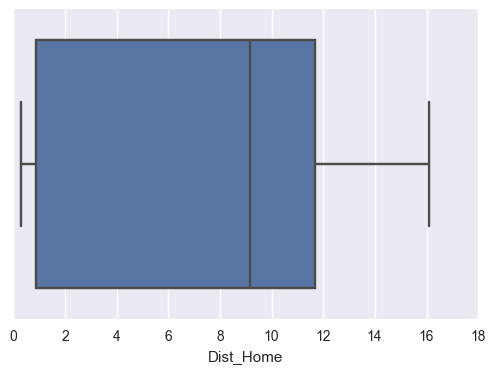

In [108]:
sns.boxplot(Data.Dist_Home[~((l==-1)|(l==homec))])

In [107]:
meandist = np.mean(Data.Dist_Home[~((l==-1)|(l==homec))])
meddist = np.median(Data.Dist_Home[~((l==-1)|(l==homec))])
print(meandist)
print(meddist)

7.176070968129095
9.16035838245


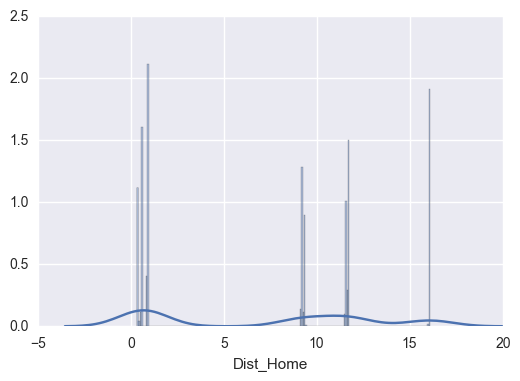

In [74]:
sns.distplot(Data.Dist_Home[l>0],bins=200)

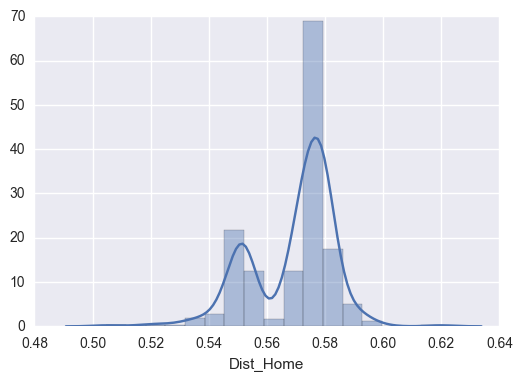

In [73]:
sns.distplot(Data.Dist_Home[l==2])

In [36]:
coord = pd.DataFrame({'coord':[list(dArray)]})

In [37]:
coord

,coord
0,"[[41.895196, -87.624259], [41.895462, -87.6244..."


In [26]:
dist = vincenty((home),(dArray[0,:])).meters/1000

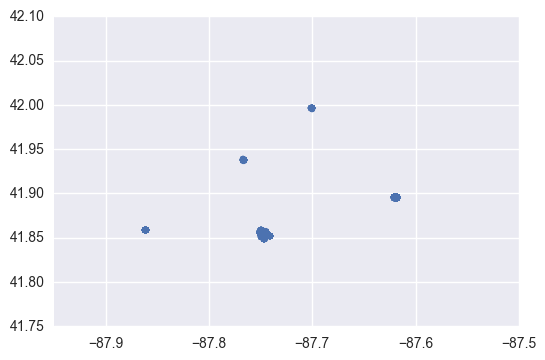

In [164]:
sns.regplot(dArray[l!=-1][:,1],dArray[l!=-1][:,0],scatter=True,fit_reg=False)

In [158]:
len(l)

97448

In [78]:
dArray[l==homeInd][:,0]

array([ 41.854705,  41.855227,  41.856106, ...,  41.856452,  41.855366,
        41.854882])

In [44]:
l=clusters.labels_
print(len(l))
np.unique(l)

183368


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [45]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

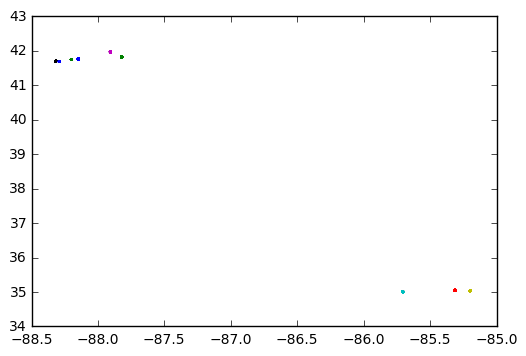

In [46]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]], s=1)

In [173]:
dArray[l!=-1][:,1].shape

(92411,)

In [48]:
gmap = gmplot.GoogleMapPlotter(41.84,-87.75,12)
for c in np.unique(l[l!=-1]):
    m = [np.mean(dArray[l==c][:,0]), np.mean(dArray[l==c][:,1])]
    # Size based on physical space covered by cluster
    s1 = (np.max(dArray[l==c][:,0])-np.min(dArray[l==c][:,0]))
    s2 = (np.max(dArray[l==c][:,1])-np.min(dArray[l==c][:,1]))
    print(s1*s2)
    
#     # Size based on time spent in cluster
#     s1 = sum(l==c)
#     s2=1000
#     print(math.sqrt(s1*s2))
    
    # colorscale based on weartime fraction
    col = sum((l==c) & (Data['Wear/Non-Wear']=='Wear'))/sum(l==c)
    
    gmap.scatter([m[0], m[0]],[m[1], m[1]],color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=math.sqrt(s1*s2/homeSize)*8, marker=False)
# Save as html
gmap.draw("CBR31_large.html")

2.15136999998e-06
5.49987999968e-07
2.90872399995e-06
1.636938e-06
2.23440000001e-06
2.80098e-06
7.16379999987e-07
2.529786e-06
9.79550999967e-07


In [107]:
col

0.06706586826347305

## Local Community Clustering

In [3]:
Data = pd.read_csv('pathZ/C Brace/GPS Analysis/GPSWT/CBR31_CBrace.csv')

Lat = Data.LATITUDE
Lon = Data.LONGITUDE

Data.loc[Data['E/W']=="W","LONGITUDE"] = Data.loc[Data['E/W']=="W","LONGITUDE"]*-1

dArray = Data[["LATITUDE","LONGITUDE"]].values

In [6]:
dbscan = DBSCAN(metric='haversine', eps=1000/6371000, min_samples=int(180*len(dArray)/10000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(dArray))
t1 = time.clock()
print(t1-t0)

323.2384070918065


In [7]:
l=clusters.labels_
print(len(l))
np.unique(l)

183368


array([-1,  0,  1,  2])

In [13]:
dbscan = DBSCAN(metric='haversine', eps=25/6371000, min_samples=int(180*len(dArray)/100000), algorithm='ball_tree')

for i in np.unique(l[l!=-1]):
    clustData = dArray[l==i]
    clusters = dbscan.fit(np.radians(clustData))
    print(len(np.unique(clusters.labels_)))
    for li in np.unique(clusters.labels_):
        print(sum(clusters.labels_==li))

2
80
5008
2
784
157199
2
233
4723


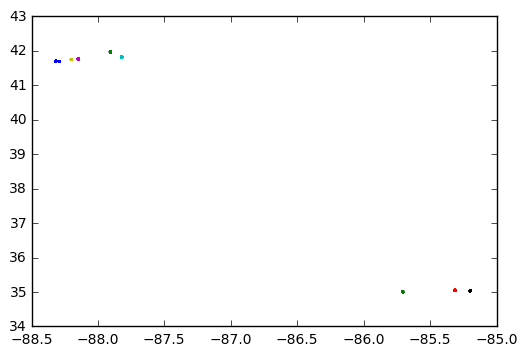

In [119]:
plt.scatter(dArray[l!=-1][:,1],dArray[l!=-1][:,0],color=colors[l[l!=-1]], s=1)

In [78]:
maxClust = -1
maxClustNum = 0
for i in range(0,len(np.unique(l))-1):
    print(i)
    if sum(l==i)>maxClustNum:
        maxClust = i
        maxClustNum = sum(l==i)
    
# HomeData = dArray[l==maxClust]
HomeData = dArray[l==0]
Wear = Data['Wear/Non-Wear'][l==maxClust] =='Wear'

0


In [90]:
dbscan = DBSCAN(metric='haversine', eps=100/6371000, min_samples=int(2000*len(HomeData)/100000), algorithm='ball_tree')
t0 = time.clock()
clusters = dbscan.fit(np.radians(HomeData))
t1 = time.clock()
print(t1-t0)

770.8210415907597


In [91]:
l=clusters.labels_
print(len(l))
np.unique(l)

247477


array([-1,  0])

In [92]:
colors=np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmykbgrcmyk'])

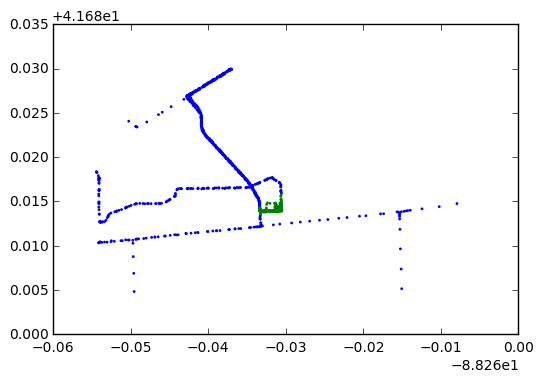

In [93]:
plt.scatter(HomeData[l!=-2][:,1],HomeData[l!=-2][:,0],color=colors[l[l!=-2]+1], s=1)

In [88]:
gmap = gmplot.GoogleMapPlotter(41.84,-87.75,12)

for c in np.unique(l[l!=-1]):
    d = np.vstack({tuple(row) for row in np.around(HomeData[l==c],decimals=5)})
    col = sum((l==c) & (Wear))/sum(l==c)
    
    gmap.scatter(d[:,0],d[:,1],color='#%02x%02x%02x' % (int(col*255), 255-int(col*125), 0), size=5, marker=False)
# Save as html
gmap.draw("SCO31.html")

In [73]:
d

array([[ 41.69438, -88.29136],
       [ 41.69415, -88.29099],
       [ 41.69386, -88.29179],
       ..., 
       [ 41.69407, -88.29129],
       [ 41.69407, -88.29111],
       [ 41.69389, -88.29309]])

In [62]:
np.vstack({tuple(row) for row in d}).shape

(29068, 2)

In [68]:
np.vstack({tuple(row) for row in np.around(HomeData[l==c],decimals=5)}).shape

(1352, 2)

In [86]:
for i, row in enumerate(d):
    print(row)

[ 41.69411 -88.29137]
[ 41.69429 -88.29119]
[ 41.69444 -88.29124]
[ 41.69396 -88.29114]
[ 41.69404 -88.29131]
[ 41.69425 -88.29111]
[ 41.69438 -88.29112]
[ 41.69395 -88.29114]
[ 41.69428 -88.29112]
[ 41.6941 -88.2913]
[ 41.69414 -88.29116]
[ 41.69422 -88.29138]
[ 41.69404 -88.2912 ]
[ 41.69392 -88.2928 ]
[ 41.69419 -88.29127]
[ 41.69415 -88.29116]
[ 41.6941  -88.29118]
[ 41.69437 -88.29109]
[ 41.69406 -88.29107]
[ 41.69416 -88.29125]
[ 41.69427 -88.29114]
[ 41.69409 -88.29119]
[ 41.69391 -88.29209]
[ 41.69436 -88.29128]
[ 41.69424 -88.29113]
[ 41.69411 -88.29127]
[ 41.69407 -88.29134]
[ 41.69388 -88.29149]
[ 41.69393 -88.29109]
[ 41.69412 -88.29112]
[ 41.694   -88.29113]
[ 41.69424 -88.29123]
[ 41.69438 -88.29117]
[ 41.69397 -88.29114]
[ 41.69417 -88.29122]
[ 41.69408 -88.29059]
[ 41.69408 -88.29131]
[ 41.69406 -88.2912 ]
[ 41.69414 -88.29101]
[ 41.69396 -88.29119]
[ 41.69423 -88.29128]
[ 41.69434 -88.29128]
[ 41.69416 -88.2911 ]
[ 41.69465 -88.29129]
[ 41.6942 -88.2912]
[ 41.69411 -88

In [87]:
d

array([[ 41.69411, -88.29137],
       [ 41.69429, -88.29119],
       [ 41.69444, -88.29124],
       ..., 
       [ 41.69401, -88.29115],
       [ 41.69418, -88.29124],
       [ 41.69409, -88.29115]])

In [89]:
col

0.32536554509403204